# Train a shallow SNN on the Randman Dataset

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import stork.datasets
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DelayGroup
from stork.connections import Connection
from stork.generators import StandardGenerator
from stork.initializers import FluctuationDrivenCenteredNormalInitializer

using delay stork version - filter cascades


## Generate Dataset

Specify the Dataset Parameters

In [2]:
torch.manual_seed(12)


dim_manifold = 1
nb_classes = 10
nb_inputs = 20
nb_time_steps = 100
step_frac = 0.5
nb_samples = 1000
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps*dt

In [3]:
data, labels = stork.datasets.make_tempo_randman(
    dim_manifold=dim_manifold,
    nb_classes=nb_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=step_frac,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed)

ds_kwargs = dict(
    nb_steps=nb_time_steps,
    nb_units=nb_inputs,
    time_scale=1.0
)

# Split into train, test and validation set
datasets = [stork.datasets.RasDataset(ds, **ds_kwargs) for ds in
            stork.datasets.split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)]
ds_train, ds_valid, ds_test = datasets

print(len(ds_train), len(ds_valid), len(ds_test))

8000 1000 1000


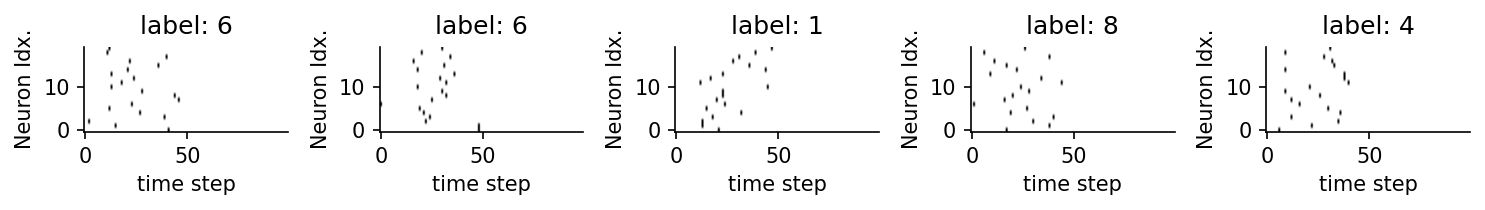

In [4]:
fig, ax = plt.subplots(1,5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()


## Set up the model

In [ ]:
# Model Parameters
batch_size = 250
beta = 20
device = torch.device("cuda:0")
dtype = torch.float


nb_hidden_units = 128
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = duration

lr = 5e-3
nb_epochs = 50

In [37]:
act_fn = stork.activations.CustomSpike

act_fn.beta = beta
neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [38]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(LIFGroup(
    nb_hidden_units,
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    activation=act_fn))

delay_neurons = model.add_group(DelayGroup(
    src=hidden_neurons,
    max_delay_timesteps=nb_time_steps//2,
))

hidden_neurons2 = model.add_group(LIFGroup(
    nb_hidden_units,
    tau_mem=tau_mem,
    tau_syn=tau_syn,
    activation=act_fn))

readout_group = model.add_group(ReadoutGroup(
    nb_classes,
    tau_mem=tau_readout,
    tau_syn=tau_syn,
    initial_state=-1e-2))



Add synapses between the neuron groups

In [39]:
con = model.add_connection(Connection(input_group, hidden_neurons))
con_hid = model.add_connection(Connection(delay_neurons, hidden_neurons2))
con_ro = model.add_connection(Connection(hidden_neurons2, readout_group))

Add regularizers

In [40]:
# Define regularizer parameters (set regularizer strenght to 0, if you don't want to use them)
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = 4       # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time

# Define regularizer list
regs = []

regLB = stork.regularizers.LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = stork.regularizers.UpperBoundL2(upperBoundL2Strength,threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [41]:
sigma_u = 1.0
nu = nb_spikes/duration

initializer = FluctuationDrivenCenteredNormalInitializer(sigma_u = 1.0, nu = nu, timestep = dt)

con.init_parameters(initializer=initializer)
con_hid.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [42]:
for g in model.groups:
    print(g.name)

Input
LIFGroup
DelayGroup
LIFGroup
Readout


In [43]:
model.add_monitor(stork.monitors.SpikeCountMonitor(model.groups[1]))
model.add_monitor(stork.monitors.StateMonitor(model.groups[1], "out"))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [44]:
loss_stack = stork.loss_stacks.MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [45]:
opt = stork.optimizers.SMORMS3
generator = StandardGenerator(nb_workers=2)

In [46]:
model.configure(input=input_group,
                output=readout_group,
                loss_stack=loss_stack,
                generator=generator,
                optimizer=opt,
                optimizer_kwargs=dict(lr=lr),
                time_step=dt)

Before we train the model, we monitor the spikes

In [47]:
# Monitors spike counts before training
res = model.monitor(ds_test)
total_spikes = torch.sum(res[0]).item()

results = {}
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(1)]
results["avg_layer_freq_init"] = [nb/len(ds_test)/duration/nb_hidden_units for nb in total_spikes_per_layer]

print(results)

{'avg_layer_freq_init': [7.3773046875]}


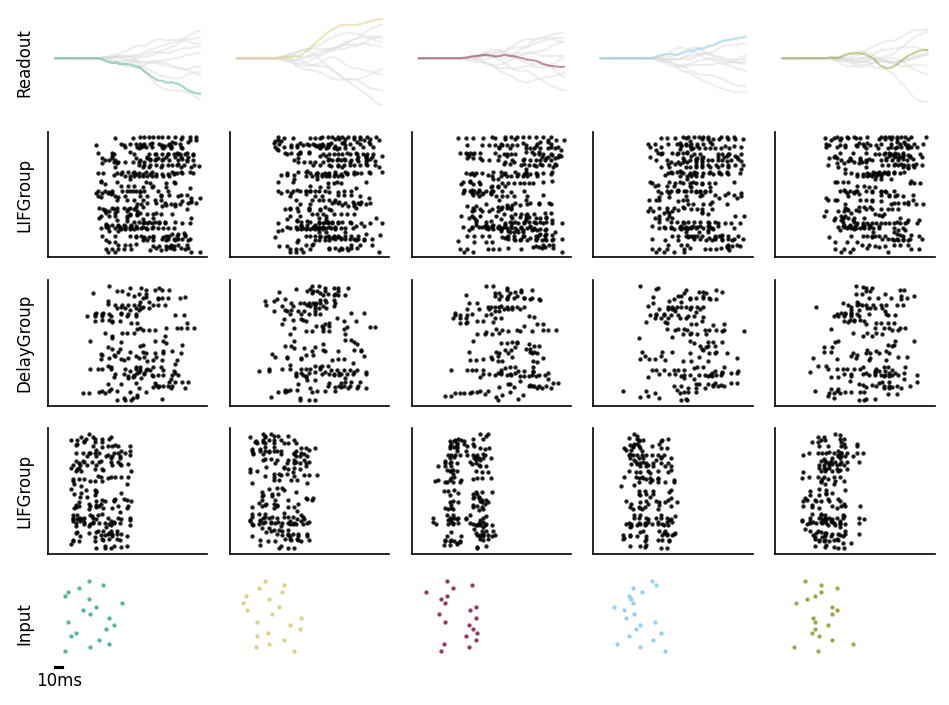

In [48]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=ds_test,
    point_alpha=0.8,
    show_predictions=False)

## Training

takes around 13-20 minutes

In [ ]:
# for name, param in model.named_parameters():
#     print(name, end="")
#     if "weight" in name:
#         # do not require grad
#         param.requires_grad = False
#         print(": no grad")
#     else:
#         print()


group3.delays
con1.op.weight: no grad
con2.op.weight: no grad
con3.op.weight: no grad


In [50]:
len(ds_train), len(ds_test)

(8000, 1000)

In [51]:
model.groups[2].buffer.shape

torch.Size([50, 250, 128])

In [52]:
# print(model.groups[2].delays)
print(torch.mean(model.groups[2].delays))

tensor(26.6990, device='cuda:0', grad_fn=<MeanBackward0>)


In [53]:
history = model.fit_validate(
    ds_train,
    ds_valid,
    nb_epochs=nb_epochs,
    verbose=True)


00  loss=4.13 reg_loss=3.61e-05 acc=0.0945 -- val_loss=4.01 val_reg_loss=3.6e-05 val_acc=0.11 t_iter=6.77
01  loss=4.12 reg_loss=3.61e-05 acc=0.0961 -- val_loss=3.98 val_reg_loss=3.6e-05 val_acc=0.113 t_iter=6.80
02  loss=4.08 reg_loss=3.61e-05 acc=0.097 -- val_loss=3.98 val_reg_loss=3.6e-05 val_acc=0.11 t_iter=6.12
03  loss=4.1 reg_loss=3.61e-05 acc=0.0984 -- val_loss=4 val_reg_loss=3.6e-05 val_acc=0.111 t_iter=5.54
04  loss=4.11 reg_loss=3.61e-05 acc=0.0969 -- val_loss=3.97 val_reg_loss=3.6e-05 val_acc=0.117 t_iter=5.31
05  loss=4.08 reg_loss=3.61e-05 acc=0.0969 -- val_loss=3.96 val_reg_loss=3.6e-05 val_acc=0.116 t_iter=5.52
06  loss=4.07 reg_loss=3.61e-05 acc=0.0965 -- val_loss=3.93 val_reg_loss=3.6e-05 val_acc=0.11 t_iter=5.40
07  loss=4.06 reg_loss=3.61e-05 acc=0.0966 -- val_loss=3.94 val_reg_loss=3.6e-05 val_acc=0.11 t_iter=5.38
08  loss=4.04 reg_loss=3.61e-05 acc=0.0998 -- val_loss=3.93 val_reg_loss=3.6e-05 val_acc=0.115 t_iter=5.30
09  loss=4.04 reg_loss=3.61e-05 acc=0.0989 -- 

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [54]:
for key, val in history.items():
    if key in results:
        results[key] += val.tolist()
    else:
        results[key] = val.tolist()

In [55]:
# print(model.groups[2].delays)``
print(torch.mean(model.groups[2].delays))

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
for con in model.connections:
    print(con.name, torch.sum(con.op.weight.grad))

In [ ]:
# torch.sum(model.groups[2].out).backward(torch.tensor(10))

In [ ]:
print(model.groups[2].delays.grad)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

group3.delays True
con1.op.weight False
con2.op.weight False
con3.op.weight False


In [ ]:
from graphviz import Digraph
import torch
from torch.autograd import Variable

from torchviz import make_dot

In [ ]:
# make_dot(model.groups[2].delays,  params=dict(model.named_parameters()), show_attrs=False, show_saved=False)

In [ ]:
# make_dot(model.groups[2].out,  params=dict(model.named_parameters()))

#### Monitor the model again after training

In [ ]:
res = model.monitor(ds_test)
total_spikes_per_layer = [torch.sum(res[i]).item()for i in range(1)]
results["avg_layer_freq"] = [nb/len(ds_test)/duration/nb_hidden_units for nb in total_spikes_per_layer]


## Test

In [ ]:
scores = model.evaluate(ds_test).tolist()
l, _, a = scores
if "test_loss" in results:
    results["test_loss"].append(l)
    results["test_acc"].append(a)
else:
    results["test_loss"] = [l]
    results["test_acc"]  = [a]

Test loss:  3.680699944496155
Test acc.:  9.0 %


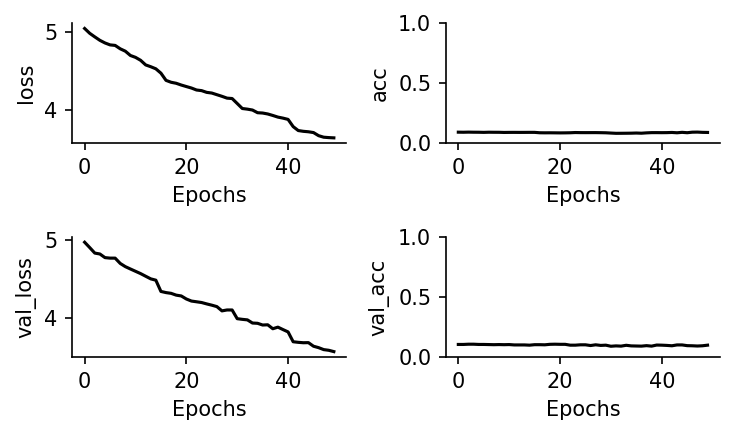

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(5,3), dpi=150)

for i, n in enumerate(["loss", "acc", "val_loss", "val_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i-2]

    a.plot(results[n], color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

print("Test loss: ", results["test_loss"][-1])
print("Test acc.: ", round(results["test_acc"][-1]*100, 2), "%")

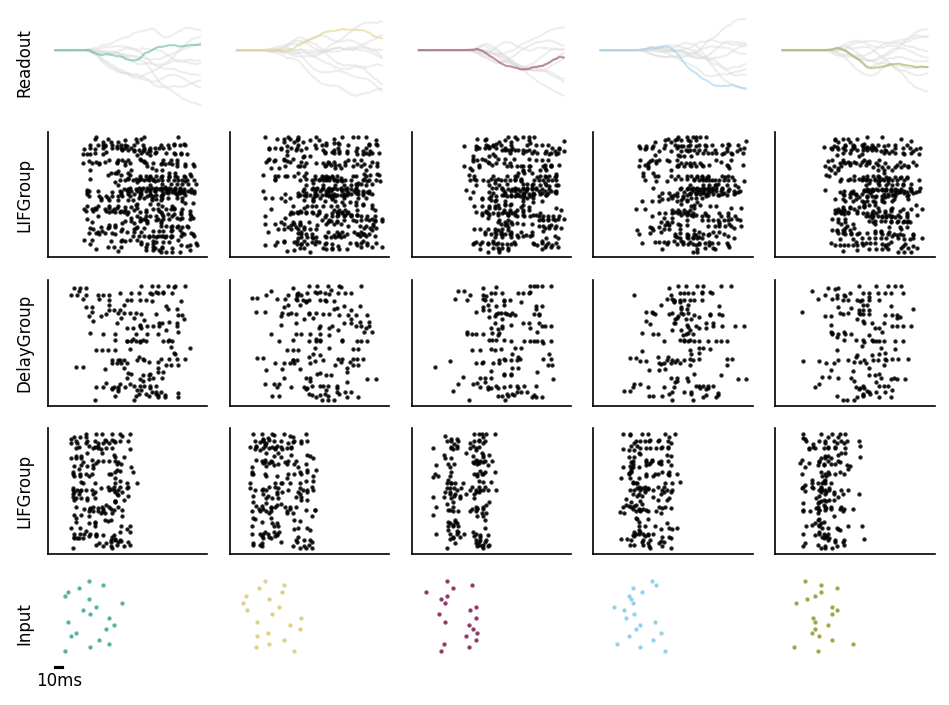

In [ ]:
plt.figure(dpi=150)
stork.plotting.plot_activity_snapshot(
    model,
    data=ds_test,
    point_alpha=0.8,
    show_predictions=False,
    nb_samples=5)